In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pySurrogate
import gwsurrogate
from gwsurrogate.new import spline_coef_evaluation
from gwsurrogate.new import surrogate

import tqdm
import sys

In [4]:
# Load amp/phase surrogate
sur = gwsurrogate.EvaluateSurrogate('../surrogate_downloads/SpEC_q1_10_NoSpin_nu5thDegPoly.h5')

loading surrogate mode... l2_m0
loading surrogate mode... l2_m1
loading surrogate mode... l2_m2
loading surrogate mode... l3_m1
loading surrogate mode... l3_m2
loading surrogate mode... l3_m3
loading surrogate mode... l4_m2
loading surrogate mode... l4_m3
loading surrogate mode... l4_m4
loading surrogate mode... l5_m2
loading surrogate mode... l5_m3
loading surrogate mode... l5_m4
loading surrogate mode... l5_m5
loading surrogate mode... l6_m3
loading surrogate mode... l6_m4
loading surrogate mode... l6_m5
loading surrogate mode... l6_m6
loading surrogate mode... l7_m5
loading surrogate mode... l7_m6
loading surrogate mode... l7_m7
loading surrogate mode... l8_m6
loading surrogate mode... l8_m7
loading surrogate mode... l8_m8


[(2, 0), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 2), (4, 3), (4, 4), (5, 2), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 5), (7, 6), (7, 7), (8, 6), (8, 7), (8, 8)]


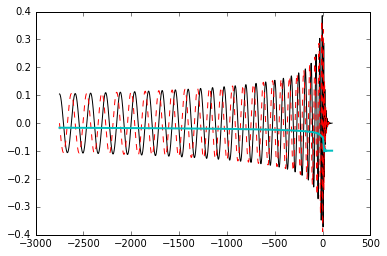

In [14]:
# Evaluate it, make sure we get the (2, 0) mode as well
lm_modes, t, hreal, himag = sur(1.2, mode_sum=False, fake_neg_modes=False)
print lm_modes

plt.plot(t, hreal[:, 2], 'k')
plt.plot(t, himag[:, 2], 'r--')
plt.plot(t, hreal[:, 0], 'c', lw=2)
plt.show()

In [29]:
# We first need a complex empirical interpolant for each mode.
# Let's first determine how many basis vectors are needed (22 should be sufficient...)

def mode_evaluations(ell, m, nq):
    print 'Evaluating the (%s, %s) mode for %s mass ratios'%(ell, m, nq)
    sys.stdout.flush()
    qvals = np.linspace(1., 10., nq)
    evals = []
    for i in tqdm.trange(nq):
        q = qvals[i]
        lm_modes, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False, ell=[ell], m=[m])
        evals.append(hreal + 1.j*himag)
    return np.array(evals)

def max_proj_err(resids):
    return np.sqrt(np.max([abs(r.dot(r.conjugate())) for r in resids]))

def get_basis_and_errs(evals, tol):
    print 'getting basis...'
    sys.stdout.flush()
    basis = pySurrogate.ei.buildPySurSVD(evals, tol)
    coefs = np.sum(evals[:, :, np.newaxis] * basis.T.conjugate(), 1)
    errs = [max_proj_err(evals)]
    print 'getting projection errors...'
    sys.stdout.flush()
    for n in tqdm.trange(1, len(basis)+1):
        resids = evals - coefs[:, :n].dot(basis[:n])
        errs.append(max_proj_err(resids))
    return basis, errs

Evaluating the (2, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:01<00:00, 66.47it/s]

getting basis...
getting projection errors...



100%|██████████| 26/26 [00:06<00:00,  3.37it/s]


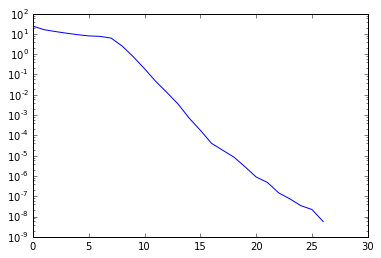

In [32]:
# Try out building a basis for the (2, 2) mode
nTS = 100 # Should be enough
h22 = mode_evaluations(2, 2, nTS)
basis, errs = get_basis_and_errs(h22, 1.e-10)
plt.semilogy(range(len(errs)), errs, label='(2, 2) mode')
plt.show()

Evaluating the (4, 4) mode for 100 mass ratios


100%|██████████| 100/100 [00:01<00:00, 66.68it/s]

getting basis...
getting projection errors...



100%|██████████| 41/41 [00:13<00:00,  1.99it/s]


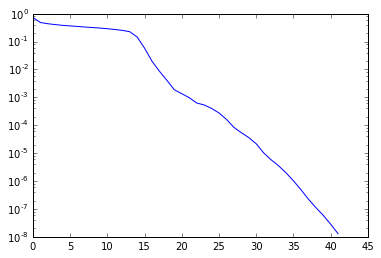

In [33]:
# Try out building a basis for the (4, 4) mode
h44 = mode_evaluations(4, 4, nTS)
basis, errs = get_basis_and_errs(h44, 1.e-10)
plt.semilogy(range(len(errs)), errs, label='(2, 2) mode')
plt.show()

In [35]:
# We know that a basis size of 22 should be enough.
# We could improve the computational cost by using a smaller basis for some modes.
# We could also build one single (larger) basis for all modes, which can accelerate RapidPE.
nTS = 100
basis_tol = 1.e-10
n_basis = 22

empirical_interpolant_bases = {}
empirical_node_indices = {}

for i, (ell, m) in enumerate(lm_modes):
    mode_evals = mode_evaluations(ell, m, nTS)
    basis, errs = get_basis_and_errs(mode_evals, basis_tol)
    basis = basis[:n_basis]
    errs = errs[:n_basis]
    print 'Largest projection error of final basis is %s'%(errs[-1])
    print 'Getting empirical interpolant...'
    sys.stdout.flush()
    ei_basis, node_indices = pySurrogate.ei.buildPySurEI(basis)
    empirical_interpolant_bases[ell, m] = ei_basis
    empirical_node_indices[ell, m] = node_indices

Evaluating the (2, 0) mode for 100 mass ratios


100%|██████████| 100/100 [00:01<00:00, 82.26it/s]

getting basis...
getting projection errors...



100%|██████████| 7/7 [00:01<00:00,  5.31it/s]

Largest projection error of final basis is 1.68420278229e-08
Getting empirical interpolant...
Evaluating the (2, 1) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 84.72it/s]

getting basis...
getting projection errors...



100%|██████████| 24/24 [00:06<00:00,  3.19it/s]

Largest projection error of final basis is 1.40743066748e-07
Getting empirical interpolant...
Evaluating the (2, 2) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 63.77it/s]

getting basis...
getting projection errors...



100%|██████████| 26/26 [00:06<00:00,  3.57it/s]

Largest projection error of final basis is 4.78809145594e-07
Getting empirical interpolant...
Evaluating the (3, 1) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 68.34it/s]

getting basis...
getting projection errors...



100%|██████████| 34/34 [00:09<00:00,  3.05it/s]

Largest projection error of final basis is 4.07977793446e-05
Getting empirical interpolant...
Evaluating the (3, 2) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 72.22it/s]

getting basis...
getting projection errors...



100%|██████████| 35/35 [00:10<00:00,  2.29it/s]

Largest projection error of final basis is 8.288134877e-05
Getting empirical interpolant...
Evaluating the (3, 3) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 71.80it/s]

getting basis...
getting projection errors...



100%|██████████| 33/33 [00:09<00:00,  2.73it/s]

Largest projection error of final basis is 0.000113575652352
Getting empirical interpolant...
Evaluating the (4, 2) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 68.95it/s]

getting basis...
getting projection errors...



100%|██████████| 33/33 [00:08<00:00,  2.99it/s]

Largest projection error of final basis is 1.80801563069e-05
Getting empirical interpolant...
Evaluating the (4, 3) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 78.39it/s]

getting basis...
getting projection errors...



100%|██████████| 37/37 [00:12<00:00,  2.33it/s]

Largest projection error of final basis is 0.000146681515869
Getting empirical interpolant...
Evaluating the (4, 4) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 87.05it/s]

getting basis...
getting projection errors...



100%|██████████| 41/41 [00:11<00:00,  2.29it/s]

Largest projection error of final basis is 0.000967968481898
Getting empirical interpolant...
Evaluating the (5, 2) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 82.92it/s]

getting basis...
getting projection errors...



100%|██████████| 37/37 [00:10<00:00,  2.84it/s]

Largest projection error of final basis is 6.22170836297e-06
Getting empirical interpolant...
Evaluating the (5, 3) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 59.55it/s]

getting basis...
getting projection errors...



100%|██████████| 38/38 [00:10<00:00,  2.69it/s]

Largest projection error of final basis is 7.75471619972e-05
Getting empirical interpolant...
Evaluating the (5, 4) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 75.63it/s]

getting basis...
getting projection errors...



100%|██████████| 44/44 [00:13<00:00,  2.52it/s]

Largest projection error of final basis is 0.000320477837987
Getting empirical interpolant...
Evaluating the (5, 5) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 75.10it/s]

getting basis...
getting projection errors...



100%|██████████| 48/48 [00:15<00:00,  2.68it/s]

Largest projection error of final basis is 0.00245957736825
Getting empirical interpolant...
Evaluating the (6, 3) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 60.57it/s]

getting basis...
getting projection errors...



100%|██████████| 36/36 [00:09<00:00,  3.08it/s]

Largest projection error of final basis is 3.92769924762e-06
Getting empirical interpolant...
Evaluating the (6, 4) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 76.76it/s]

getting basis...
getting projection errors...



100%|██████████| 42/42 [00:12<00:00,  2.66it/s]

Largest projection error of final basis is 0.000121812725055
Getting empirical interpolant...
Evaluating the (6, 5) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 81.89it/s]

getting basis...
getting projection errors...



100%|██████████| 46/46 [00:14<00:00,  2.30it/s]

Largest projection error of final basis is 0.000251277264633
Getting empirical interpolant...
Evaluating the (6, 6) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 80.61it/s]

getting basis...
getting projection errors...



100%|██████████| 57/57 [00:19<00:00,  2.71it/s]

Largest projection error of final basis is 0.00722968719
Getting empirical interpolant...
Evaluating the (7, 5) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 64.00it/s]

getting basis...
getting projection errors...



100%|██████████| 48/48 [00:15<00:00,  2.20it/s]

Largest projection error of final basis is 9.4291878647e-05
Getting empirical interpolant...
Evaluating the (7, 6) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 77.90it/s]

getting basis...
getting projection errors...



100%|██████████| 52/52 [00:16<00:00,  2.75it/s]

Largest projection error of final basis is 0.000255731557381
Getting empirical interpolant...
Evaluating the (7, 7) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 74.02it/s]

getting basis...
getting projection errors...



100%|██████████| 61/61 [00:21<00:00,  2.35it/s]

Largest projection error of final basis is 0.00295575637964
Getting empirical interpolant...
Evaluating the (8, 6) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 67.68it/s]

getting basis...
getting projection errors...



100%|██████████| 53/53 [00:17<00:00,  2.25it/s]

Largest projection error of final basis is 6.33295804399e-05
Getting empirical interpolant...
Evaluating the (8, 7) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 58.32it/s]

getting basis...
getting projection errors...



100%|██████████| 65/65 [00:21<00:00,  2.29it/s]

Largest projection error of final basis is 0.000148265269174
Getting empirical interpolant...
Evaluating the (8, 8) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 64.89it/s]

getting basis...
getting projection errors...



100%|██████████| 71/71 [00:24<00:00,  2.34it/s]

Largest projection error of final basis is 0.00144193968277
Getting empirical interpolant...


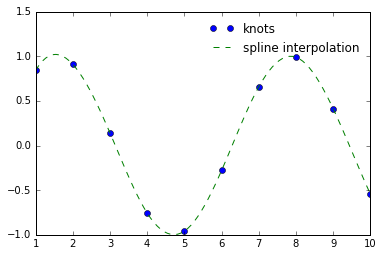

In [77]:
# Now we need to build a spline for the real/imaginary parts of each empirical node.
# For simplicity we will use the same knots for all modes and nodes.

# Here's how we build a simple spline:
nQ = 10
qvals = np.linspace(1., 10., nQ)
yvals = np.sin(qvals)
spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,), origin=[1.], spacings=[9. / (nQ-1)])
spline.decompose() # Do the LU decomposition of the spline coefficient matrix
spline.solve(yvals) # Use the LU decomposition to obtain spline coefficients
coefs = spline.coefs

# And we can evaluate it:
ts_grid = surrogate.TensorSplineGrid([qvals])

def eval_spline(ts_grid, coefs, x):
    # Nudge to avoid being outside valid range
    if x - 10. > -1.e-12:
        x = 10. - 1.e-12
    if x < 1.e-12:
        x = 1.e-12
        
    imin_vals, eval_prods = ts_grid([x])
    i0 = imin_vals[0]
    return np.sum(coefs[i0: i0+4] * eval_prods)

qtest = np.linspace(1., 10., nQ * 10)
ytest = np.array([eval_spline(ts_grid, coefs, q) for q in qtest])
plt.plot(qvals, yvals, 'o', label='knots')
plt.plot(qtest, ytest, '--', label='spline interpolation')
plt.legend(frameon=False)
plt.show()


100%|██████████| 11/11 [00:26<00:00,  2.69s/it]


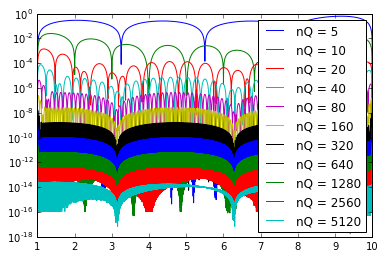

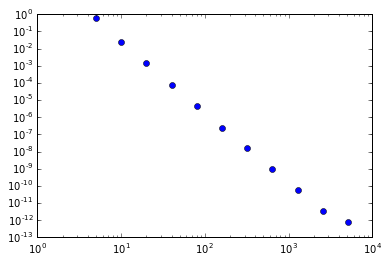

In [80]:
# Let's show that a simple spline converges well:

def simple_spline_errors(nQ, nQTest):
    qvals = np.linspace(1., 10., nQ)
    yvals = np.sin(qvals)
    spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,), origin=[1.], spacings=[9. / (nQ-1)])
    spline.decompose()
    spline.solve(yvals)
    coefs = spline.coefs
    ts_grid = surrogate.TensorSplineGrid([qvals])
    qtest = np.linspace(1., 10., nQTest)
    ytest = np.array([eval_spline(ts_grid, coefs, q) for q in qtest])
    return abs(ytest - np.sin(qtest))

nqvals = [5]
for i in range(10):
    nqvals.append(2 * nqvals[-1])
nQTest = nqvals[-1] * 2
qtest = np.linspace(1., 10., nQTest)
errs = []
for i in tqdm.trange(len(nqvals)):
    nq = nqvals[i]
    errs.append(simple_spline_errors(nq, nQTest))

for i, nq in enumerate(nqvals):
    plt.semilogy(qtest, errs[i], label='nQ = %s'%(nq))
plt.legend()
plt.show()

plt.loglog(nqvals, [np.max(err) for err in errs], 'o')
plt.show()

In [152]:
# Now let's build a whole spline surrogate

def get_mode_spline_coefs(ell, m, qvals, spline):
    node_indices = empirical_node_indices[ell, m]
    real_nodes = []
    imag_nodes = []
    for q in qvals:
        lm_modes, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False, ell=[ell], m=[m])
        real_nodes.append(hreal[node_indices])
        imag_nodes.append(himag[node_indices])
    
    real_nodes = np.array(real_nodes)
    imag_nodes = np.array(imag_nodes)
    real_coefs = []
    imag_coefs = []
    for i in range(len(node_indices)):
        spline.solve(real_nodes[:, i])
        real_coefs.append(np.copy(spline.coefs))
        spline.solve(imag_nodes[:, i])
        imag_coefs.append(np.copy(spline.coefs))
    return np.array(real_coefs), np.array(imag_coefs)

def build_spline_surrogate(nQ):
    qvals = np.linspace(1., 10., nQ)
    spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,), origin=[1.], spacings=[9. / (nQ-1)])
    spline.decompose()
    
    mode_data = {}
    for i in tqdm.trange(len(lm_modes)):
        ell, m = lm_modes[i]
        real_coefs, imag_coefs = get_mode_spline_coefs(ell, m, qvals, spline)
        mode_data[ell, m] = (empirical_interpolant_bases[ell, m], real_coefs, imag_coefs)
        
    spline_surrogate = surrogate.FastTensorSplineSurrogate(
            name = 'SpEC_1d_nonspinning_%s_spline_knots',
            domain = t,
            param_space = surrogate.ParamSpace('Nonspinning_q10', [surrogate.ParamDim('q', 1, 10)]),
            knot_vecs = [qvals],
            mode_data = mode_data,
            modes = lm_modes,
    )
    
    return spline_surrogate

def waveform_norm(h):
    return np.sqrt(np.sum(abs(h**2)))

def waveform_error(h1, h2):
    return waveform_norm(h1 - h2) / waveform_norm(h1)

def many_h_evals(qvals):
    h_evals = []
    for i in tqdm.trange(len(qvals)):
        q = qvals[i]
        _, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False)
        h_evals.append((hreal + 1.j*himag).T)
    return h_evals

def test_spline_surrogate(spline_surrogate, nqtest, h_evals):
    qtest = np.linspace(1., 10., nqtest)
    errs = []
    for i in tqdm.trange(len(qtest)):
        q = qtest[i]
        h = h_evals[i]
        spline_modes = spline_surrogate([q])
        h_spline = np.array([spline_modes[k] for k in lm_modes])
        errs.append(waveform_error(h, h_spline))
    return np.array(errs)



In [151]:
errs = []
nqs = [5, 10, 20, 40, 80]
nqtest = 150
qtest = np.linspace(1., 10., nqtest)
h_evals = many_h_evals(qtest)
for nq in nqs:
    spline_sur = build_spline_surrogate(nq)
    errs.append(test_spline_surrogate(spline_sur, nqtest, h_evals))
    print nq, np.max(errs[-1])
    sys.stdout.flush()

100%|██████████| 150/150 [00:38<00:00,  3.76it/s]

5 2.02425371313



100%|██████████| 150/150 [00:38<00:00,  4.12it/s]

10 1.5276969199



100%|██████████| 150/150 [00:38<00:00,  4.36it/s]

20 0.45238000936



100%|██████████| 150/150 [00:36<00:00,  4.24it/s]

40 0.0204894306676



100%|██████████| 150/150 [00:37<00:00,  3.36it/s]

80 0.00147663697787


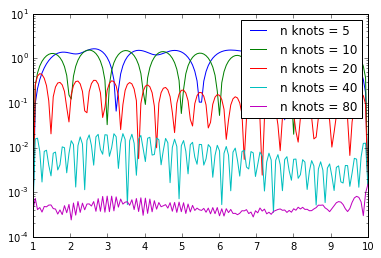

In [153]:
for nq, err in zip(nqs, errs):
    plt.semilogy(qtest, err, label='n knots = %s'%(nq))
plt.legend()
plt.show()

In [155]:
# Add a couple more (better) spline surrogates...
nqs = nqs + [160, 320]
for nq in [160, 320]:
    spline_sur = build_spline_surrogate(nq)
    errs.append(test_spline_surrogate(spline_sur, nqtest, h_evals))
    print nq, np.max(errs[-1])
    sys.stdout.flush()

100%|██████████| 150/150 [00:37<00:00,  3.97it/s]

160 0.00147663697794



100%|██████████| 150/150 [00:37<00:00,  4.32it/s]

320 0.00147663697794


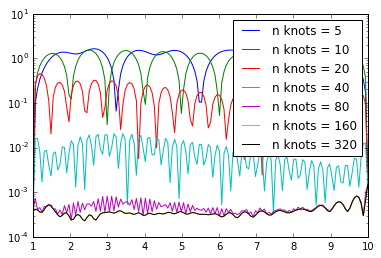

In [156]:
for nq, err in zip(nqs, errs):
    plt.semilogy(qtest, err, label='n knots = %s'%(nq))
plt.legend()
plt.show()

In [157]:
# It looks like we reach the empirical interpolation error cutoff around 100 knots.
spline_sur = build_spline_surrogate(100)

100%|██████████| 23/23 [00:30<00:00,  1.34s/it]


In [160]:
# The spline surrogate is faster:
%%timeit
spline_sur([1.2])

1 loops, best of 3: 152 ms per loop


In [161]:
%%timeit
sur(1.2, mode_sum=False, fake_neg_modes=False)

1 loops, best of 3: 314 ms per loop


In [162]:
# Save the spline surrogate:
spline_sur.save('SpEC_q10_nonspinning_spline_surrogate.h5')

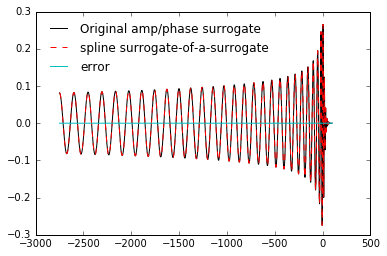

In [166]:
# Load the spline surrogate:
loaded_surrogate = surrogate.FastTensorSplineSurrogate()
loaded_surrogate.load('SpEC_q10_nonspinning_spline_surrogate.h5')
h_modes = loaded_surrogate([np.pi])
_, t, hreal, himag = sur(q=np.pi, mode_sum=False, fake_neg_modes=False)

plt.plot(t, hreal[:, 2], 'k', label='Original amp/phase surrogate')
plt.plot(t, np.real(h_modes[2, 2]), 'r--', label='spline surrogate-of-a-surrogate')
plt.plot(t, abs(hreal[:, 2] - np.real(h_modes[2, 2])), 'c', label='error')
plt.legend(frameon=False, loc='upper left')
plt.show()